In [1]:
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
from utils.model import LPTNPaper

In [20]:
model = LPTNPaper(
nrb_low=6, 
nrb_high=7,
nrb_highest=2,
num_high=2, 
in_channels=3,
kernel_size=3,
padding=1, 
num_classes=4,
device='cpu'
)

model.load_state_dict(torch.load('/Users/lava/Documents/Code/LPTN-marine/Ablation/best_Oil_6_7_2.pth', map_location=torch.device('cpu')))
model.eval()

LPTNPaper(
  (lap_pyramid): Lap_Pyramid_Conv()
  (upper_branch): upperBranch(
    (model): Sequential(
      (0): ConvTranspose2d(8, 4, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): LeakyReLU(negative_slope=0.01)
    )
  )
  (mask_branch): maskBranch(
    (model): Sequential(
      (0): ConvTranspose2d(4, 4, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): LeakyReLU(negative_slope=0.01)
    )
  )
  (trans_low): Trans_low(
    (model): Sequential(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): InstanceNorm2d(16, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (2): LeakyReLU(negative_slope=0.01)
      (3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): LeakyReLU(negative_slope=0.01)
      (5): ResidualBlock(
        (block): Sequential(
          (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): LeakyReLU(negative_slope=0.01)
     

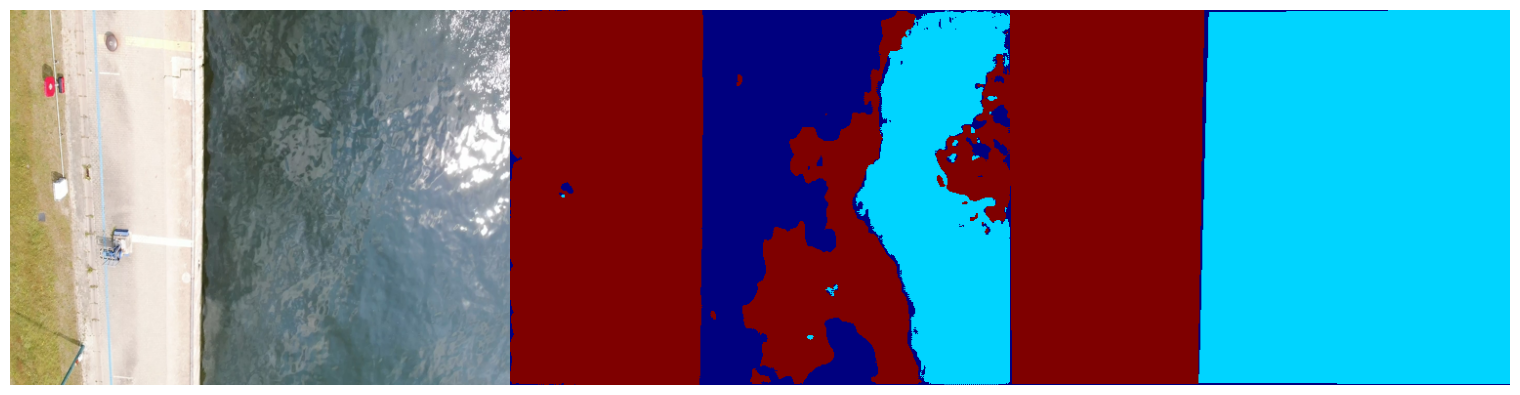

In [32]:
import torch
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.transforms as transforms
import numpy as np
import cv2

def preprocess_image(image_path):
    image = Image.open(image_path).convert('RGB')
    transform = transforms.Compose([
        transforms.Resize((384, 512)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])
    return transform(image).unsqueeze(0)

def load_mask(mask_path, oil=False):
    if oil:
        scaled_rgb_to_class = {
            (0, 0, 0): 0,         # Background
            (255, 0, 124): 1,     # Oil
            (51, 221, 255): 2,    # Water
            (255, 204, 51): 3     # Others
        }
        mask = cv2.imread(mask_path)
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
        mask = cv2.resize(mask, (512, 384))
        label_mask = np.zeros((384, 512), dtype=np.uint8)
        for rgb, cls in scaled_rgb_to_class.items():
            label_mask[(mask == rgb).all(axis=2)] = cls
        return label_mask
    else:
        mask = Image.open(mask_path).resize((512, 384), Image.NEAREST)
        return np.array(mask)

def visualize_prediction(image_path, mask_path, model, oil=False):
    image = preprocess_image(image_path)

    with torch.no_grad():
        output = model(image)
        prediction = torch.argmax(output, dim=1).squeeze(0).cpu().numpy()

    original_image = Image.open(image_path).resize((512, 384))
    mask_image = load_mask(mask_path, oil=oil)

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    for ax in axes:
        ax.axis('off')

    axes[0].imshow(original_image)
    axes[1].imshow(prediction, cmap='jet')
    axes[2].imshow(mask_image, cmap='jet')

    plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, top=1, bottom=0)
    plt.margins(0, 0)
    plt.show()

# Example usage:
image_path = '/Users/lava/Downloads/test/images/Oil (354).jpg'
mask_path = '/Users/lava/Downloads/test/masks/Oil (354).png'
visualize_prediction(image_path, mask_path, model, oil=True)


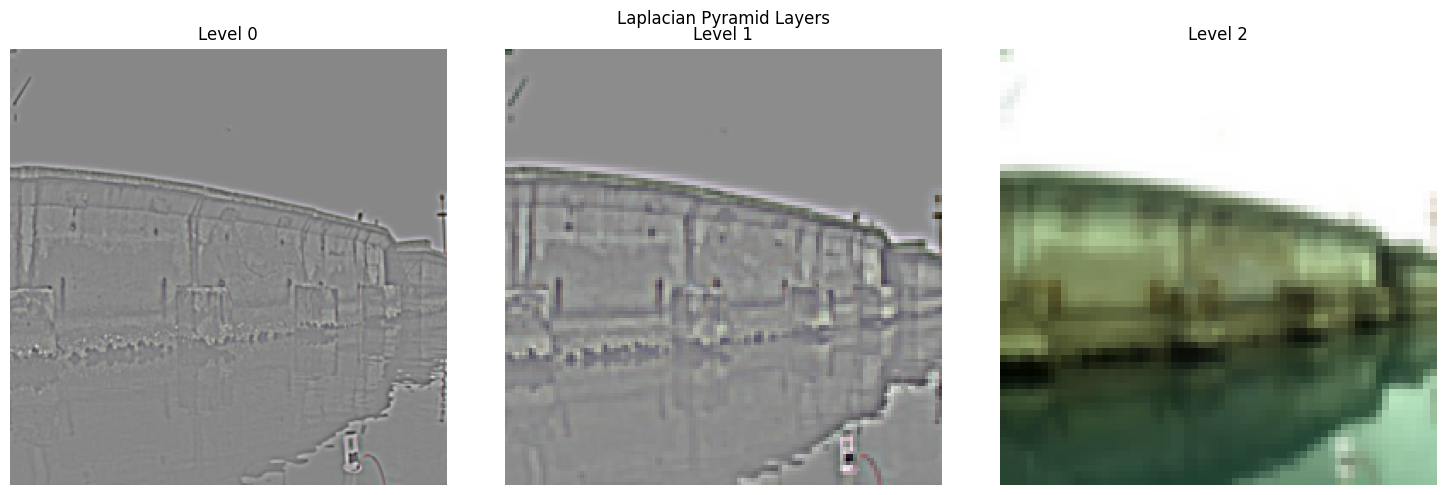

In [15]:
import torch
import torchvision.transforms as T
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

# Replace with your own image path or load using PIL.Image.open
img_path = '/Users/lava/Downloads/usv/MaSTr1325_images_512x384/0220.jpg'  # <- Provide an image here

# Load and preprocess image
image = Image.open(img_path).convert('RGB')
transform = T.Compose([
    T.Resize((256, 256)),  # smaller size for clarity
    T.ToTensor()
])
img_tensor = transform(image).unsqueeze(0)  # shape: [1, 3, H, W]

# Ensure device is CPU for visualization
device = 'cpu'
lap_pyramid = Lap_Pyramid_Conv(num_high=2, device=device)
img_tensor = img_tensor.to(device)

# Get Laplacian pyramid layers
pyr = lap_pyramid.pyramid_decom(img_tensor)

# Function to convert tensor to displayable image
def tensor_to_img(tensor):
    tensor = tensor.squeeze(0).detach().cpu()
    # Normalize to [0, 1] for display
    min_val = tensor.min()
    max_val = tensor.max()
    if max_val != min_val:
        tensor = (tensor - min_val) / (max_val - min_val)
    else:
        tensor = torch.zeros_like(tensor)
    np_img = tensor.permute(1, 2, 0).numpy()
    return np_img


# Plot pyramid layers
plt.figure(figsize=(15, 5))
for i, layer in enumerate(pyr):
    plt.subplot(1, len(pyr), i+1)
    img = tensor_to_img(layer)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f'Level {i}')
plt.suptitle('Laplacian Pyramid Layers')
plt.tight_layout()
plt.show()


In [7]:
import torch.nn as nn
import torch.nn.functional as F
import torch

# import segmentation_models_pytorch as smp
# from torchinfo import summary

class Lap_Pyramid_Conv(nn.Module):
    def __init__(self, num_high=2, device=torch.device('cuda')):
        super(Lap_Pyramid_Conv, self).__init__()
        
        self.interpolate_mode = 'bicubic'
        self.num_high = num_high
        self.device = device
        self.kernel = self.gauss_kernel()

    def gauss_kernel(self, channels=3):
        kernel = torch.tensor([[1., 4., 6., 4., 1],
                               [4., 16., 24., 16., 4.],
                               [6., 24., 36., 24., 6.],
                               [4., 16., 24., 16., 4.],
                               [1., 4., 6., 4., 1.]])
        kernel /= 256.
        kernel = kernel.repeat(channels, 1, 1, 1)
        return kernel.to(self.device)

    def downsample(self, x):
        return x[:, :, ::2, ::2]

    def upsample(self, x):
        cc = torch.cat([x, torch.zeros(x.shape[0], x.shape[1], x.shape[2], x.shape[3], device=x.device)], dim=3)
        cc = cc.view(x.shape[0], x.shape[1], x.shape[2] * 2, x.shape[3])
        cc = cc.permute(0, 1, 3, 2)
        cc = torch.cat([cc, torch.zeros(x.shape[0], x.shape[1], x.shape[3], x.shape[2] * 2, device=x.device)], dim=3)
        cc = cc.view(x.shape[0], x.shape[1], x.shape[3] * 2, x.shape[2] * 2)
        x_up = cc.permute(0, 1, 3, 2)
        return self.conv_gauss(x_up, 4 * self.kernel)

    def conv_gauss(self, img, kernel):
        img = torch.nn.functional.pad(img, (2, 2, 2, 2), mode='reflect')
        out = torch.nn.functional.conv2d(img, kernel.to(self.device), groups=img.shape[1])
        return out

    def pyramid_decom(self, HR):
        """
        Args:
            HR: High Resolution RGB image
        Returns:
            Laplacian pyramid
        """
        current = HR
        pyr = []
        for _ in range(self.num_high):
            filtered = self.conv_gauss(current, self.kernel)
            down = self.downsample(filtered).to(self.device)
            up = self.upsample(down).to(self.device)
            if up.shape[2] != current.shape[2] or up.shape[3] != current.shape[3]:
                up = nn.functional.interpolate(up, size=(current.shape[2], current.shape[3]), mode='bicubic').to(self.device)
            diff = current - up
            # diff =  torch.cat([current, diff], 1).to(self.device)
            pyr.append(diff)
            current = down.to(self.device)
        pyr.append(current)
        
        return pyr

class ResidualBlock(nn.Module):
    def __init__(self, in_features):
        super(ResidualBlock, self).__init__()

        self.block = nn.Sequential(
            nn.Conv2d(in_features, in_features, 3, padding=1),
            nn.LeakyReLU(),
            nn.Conv2d(in_features, in_features, 3, padding=1),
        )

    def forward(self, x):
        return x + self.block(x)

class Trans_low(nn.Module):
    def __init__(self, num_residual_blocks, num_classes):
        super(Trans_low, self).__init__()

        model = [nn.Conv2d(3, 16, 3, padding=1),
            nn.InstanceNorm2d(16),
            nn.LeakyReLU(),
            nn.Conv2d(16, 64, 3, padding=1),
            nn.LeakyReLU()]

        for _ in range(num_residual_blocks):
            model += [ResidualBlock(64)]

        model += [nn.Conv2d(64, 16, 3, padding=1),
            nn.LeakyReLU(),
            nn.Conv2d(16, num_classes, 3, padding=1),
            nn.LeakyReLU()]

        self.model = nn.Sequential(*model)   
    
    def forward(self, x):
        out = self.model(x)
        return out
    
class Trans_high(nn.Module):
    def __init__(self, num_residual_blocks, num_classes):
        super(Trans_high, self).__init__()
        
        model = [nn.Conv2d(3+2*num_classes, 64, 3, padding=1),
                nn.LeakyReLU()]
        
        for _ in range(num_residual_blocks):
            model += [ResidualBlock(64)]
            
        model += [nn.Conv2d(64, num_classes, 3, padding=1),
            nn.LeakyReLU()]
        
        self.model = nn.Sequential(*model)
    
    def forward(self, x):
        model_output = self.model(x)
        return model_output

class Trans_Highest(nn.Module):
    def __init__(self, num_residual_blocks, num_classes):
        super(Trans_Highest, self).__init__()

        model = []
        
        model = [nn.Conv2d(3+num_classes, 16, 3, padding=1),
            nn.LeakyReLU()]
        
        for _ in range(num_residual_blocks):
            model += [ResidualBlock(16)]
        
        model += [
            nn.Conv2d(16, num_classes, 3, padding=1)]
        
        self.model = nn.Sequential(*model)

    def forward(self, x):
        x = self.model(x)
        return x

class highBranch(nn.Module):
    def __init__(self, in_channels, kernel_size, padding, num_classes):
        super(highBranch, self).__init__()

        self.model = nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels=num_classes, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU())

    def forward(self, x):
        x = self.model(x)
        return x

class maskBranch(nn.Module):
    def __init__(self, kernel_size, padding, num_classes):
        super(maskBranch, self).__init__()

        self.model = nn.Sequential(
            nn.ConvTranspose2d(in_channels=num_classes, out_channels=num_classes, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU())

    def forward(self, x):
        x = self.model(x)
        return x   

class upperBranch(nn.Module):
    def __init__(self, kernel_size, padding, num_classes):
        super(upperBranch, self).__init__()

        self.model = nn.Sequential(
            nn.ConvTranspose2d(in_channels=2*num_classes, out_channels=num_classes, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU())

    def forward(self, x):
        output = self.model(x)
        return output

    
class LPTNPaper(nn.Module):
    def __init__(self, nrb_low=5, nrb_high=3, nrb_highest=2, in_channels=3, num_high=2, kernel_size=3, padding=1, num_classes=5, device='cpu'):
        super(LPTNPaper, self).__init__()

        self.interpolate_mode = 'bicubic'
        self.device = device
        self.lap_pyramid = Lap_Pyramid_Conv(num_high, self.device)
        trans_low = Trans_low(nrb_low, num_classes)
        trans_high = Trans_high(nrb_high, num_classes)
        upper_branch = upperBranch(kernel_size, padding, num_classes)
        mask_branch = maskBranch(kernel_size, padding, num_classes)
        trans_highest = Trans_Highest(nrb_highest, num_classes)
        high_branch = highBranch(in_channels, kernel_size, padding, num_classes)
        self.upper_branch = upper_branch
        self.mask_branch = mask_branch
        self.trans_low = trans_low
        self.trans_high = trans_high
        self.trans_highest = trans_highest
        self.high_branch = high_branch
        
    def forward(self, input_img):
        """
        Args:
            HR: High Resolution image
        Returns:
        """
        # create Laplacian Pyramid
        pyr = self.lap_pyramid.pyramid_decom(HR=input_img)
        # print("Pyramid length: ", len(pyr))
        # print("pyr[-1] size: ", pyr[-1].shape)
        # print("pyr[-2] size: ", pyr[-2].shape)
        # print("pyr[-3] size: ", pyr[-3].shape)
        
        # manually instantiating residual for readability
        residual = pyr[-1]
        # print("residual shape: ", residual.shape)
        
        # creating mask
        mask = self.trans_low(pyr[-1])
        # print("mask shape: ", mask.shape)
        
        # upsampling
        up_mask = self.mask_branch(mask)
        # print("up_mask shape: ", up_mask.shape)

        # upsampling
        up_residual = self.high_branch(residual)
        # print("up_residual shape - ", up_residual.shape)
        
        # concatenating
        higher = torch.cat([up_mask, pyr[-2], up_residual], 1)
        # print("higher shape: ", higher.shape)
        
        # creating upper image
        trans_img = self.trans_high(higher)
        # print("trans img shape: ", trans_img.shape)
        
        # concatenating upper image with up
        upper = torch.cat([trans_img, up_mask], 1)
        # print("upper shape: ", upper.shape)
        
        # applying transpose convolution
        up_upper = self.upper_branch(upper)
        # print("up_upper shape: ", up_upper.shape)
        
        # concatenating
        highest = torch.cat([up_upper, pyr[-3]], 1)
        # print("highest shape: ", highest.shape)
        
        # final layers
        output = self.trans_highest(highest)
        # print("output shape: ", output.shape)
        
        return output

In [5]:
import torch
import time
import segmentation_models_pytorch as smp
from ptflops import get_model_complexity_info

def GetModels(input_shape, encoder='resnet101', num_classes=4, device='cpu'):
    return {
        'PSPNet': smp.PSPNet(encoder_name=encoder, classes=num_classes).to(device),
        'DeepLabV3': smp.DeepLabV3(encoder_name=encoder, encoder_weights=None, classes=num_classes).to(device),
        'UNet': smp.Unet(encoder_name=encoder, encoder_weights=None, classes=num_classes).to(device),
        'LPTN': LPTNPaper(nrb_low=3, nrb_high=3, nrb_highest=3, num_high=2, in_channels=3, kernel_size=3, padding=1, num_classes=num_classes, device=device).to(device)
        # Uncomment the above line to use the LPTN model with specific parameters
    }

def BenchmarkInference(models, input_tensor, repeats=20):
    print("=== Inference Timing ===")
    for name, model in models.items():
        model.eval()
        with torch.no_grad():
            for _ in range(10):
                _ = model(input_tensor)  # Warm-up
            start = time.time()
            for _ in range(repeats):
                _ = model(input_tensor)
            end = time.time()
        avg_time = (end - start) * 1000 / repeats
        print(f"{name:12s} | Inference Time: {avg_time:.2f} ms")

def BenchmarkGFLOPs(models, input_shape):
    print("\n=== GFLOPs & Params ===")
    def prepare_input(res): return torch.randn(1, *res)
    for name, model in models.items():
        model_cpu = model.to('cpu')
        try:
            flops, params = get_model_complexity_info(
                model_cpu, input_shape, input_constructor=prepare_input,
                as_strings=False, print_per_layer_stat=False, verbose=False
            )
            gflops = flops / 1e9
            mparams = params / 1e6
        except Exception as e:
            gflops, mparams = -1, -1
            print(f"{name:12s} | GFLOPs calc failed: {e}")
            continue
        print(f"{name:12s} | GFLOPs: {gflops:.2f} | Params: {mparams:.2f}M")

# Main call
device = 'cpu'
input_shape = (3, 384, 512)
x = torch.randn(1, *input_shape).to(device)

models = GetModels(input_shape, encoder='resnet101', num_classes=3, device=device)
BenchmarkInference(models, x)
BenchmarkGFLOPs(models, input_shape)


=== Inference Timing ===
PSPNet       | Inference Time: 105.52 ms
DeepLabV3    | Inference Time: 911.55 ms
UNet         | Inference Time: 380.49 ms
LPTN         | Inference Time: 315.96 ms

=== GFLOPs & Params ===
PSPNet       | GFLOPs: 8.91 | Params: 43.30M
DeepLabV3    | GFLOPs: 181.58 | Params: 58.63M
UNet         | GFLOPs: 46.81 | Params: 51.51M
LPTN         | GFLOPs: 17.29 | Params: 0.49M
